In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 61768908 / Gaia DR3 5380853779982486144  Analysis (EA)

- revise existing https://www.aavso.org/vsx/index.php?view=detail.top&oid=738004 for ASASSN-V J114837.54-420527.2, which (incorrectly) points to the nearby TIC 61768910 / Gaia DR3 5380853779982486144
- revision is primarily on identification, range, and roughly period correction (existing one is a 2x alias from tESS data)

## TESS Data



In [2]:
tic = 61768908

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP", " GSFC-ELENAOR-LITE"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 10,2019,GSFC-ELEANOR-LITE,1800,61768908,0.0,N/A


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 61768908" SECTOR=10 AUTHOR=GSFC-ELEANOR-LITE FLUX_ORIGIN=corr_flux>

In [3]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

RS (in R☉),2.188
MS (in M☉),1.550
Magnitude (TESS),15.28
T_eff (in K),7018.0


the target (crosshari) and the contaminant (red arrow and X). Identification from Gaia DR3 Variable

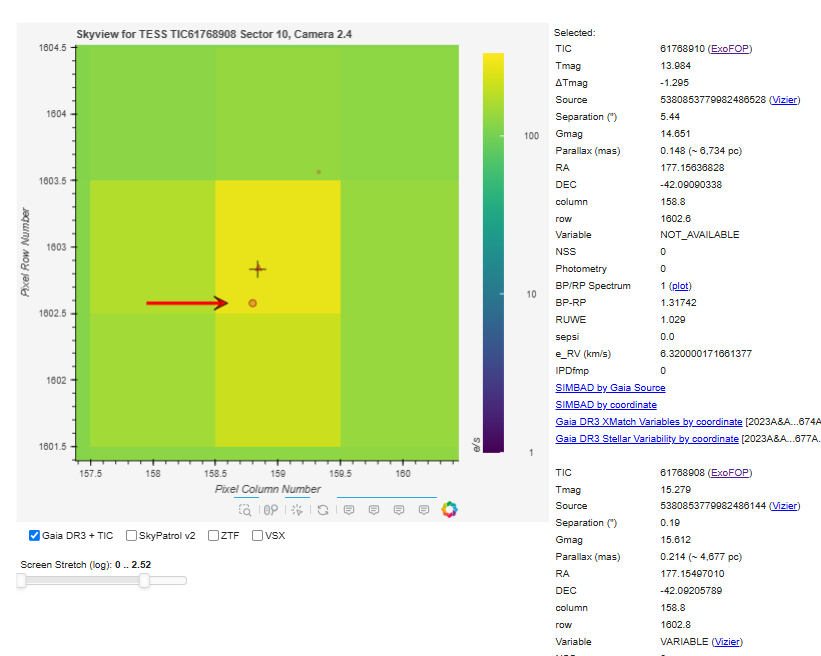


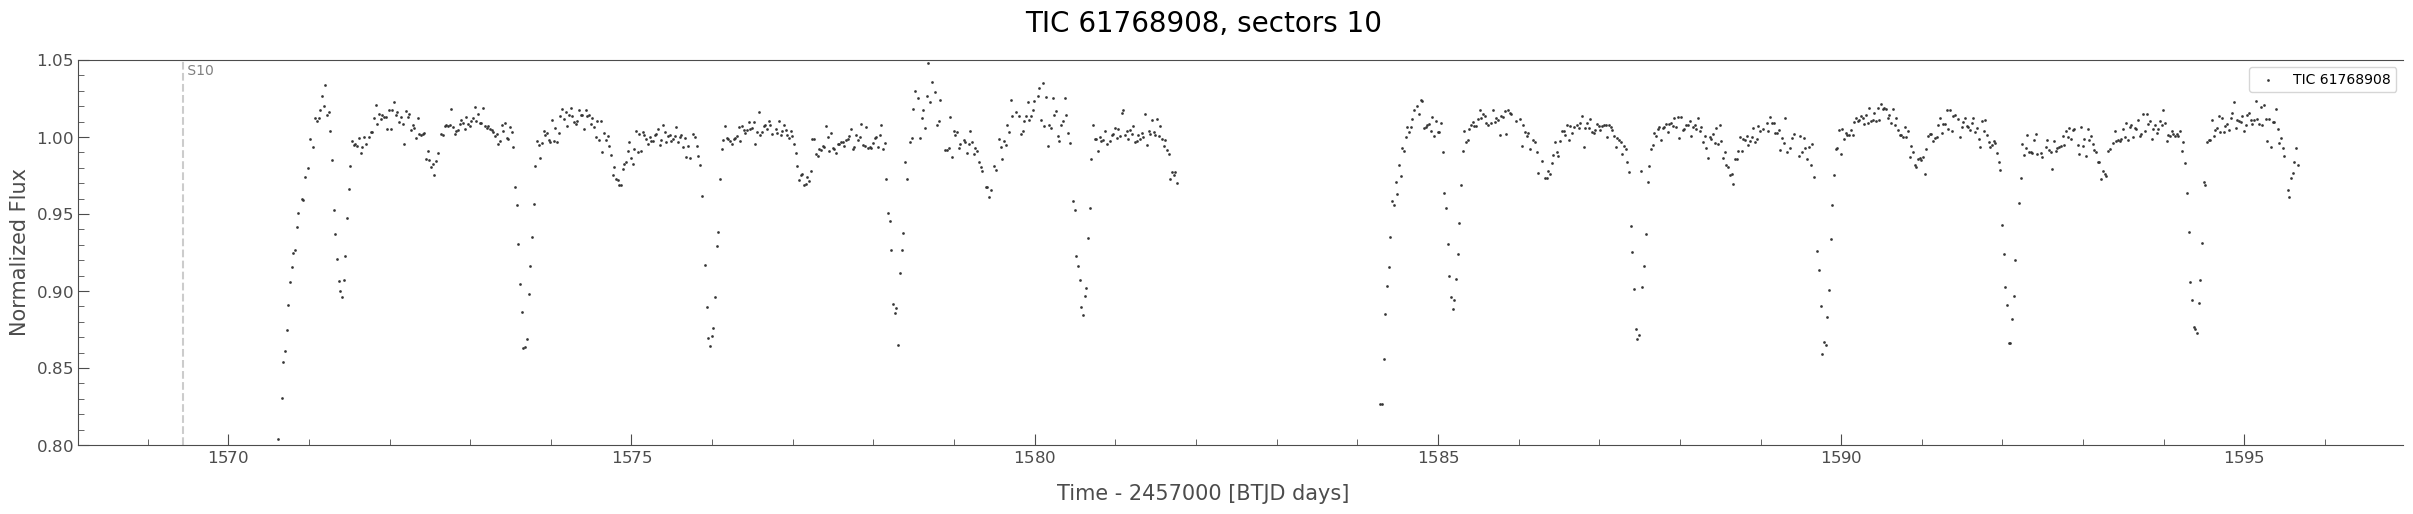

In [138]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.80, 1.05) for ax in axs];

---

## Gaia DR3 info (coordinate, etc.)

In [17]:
reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=1.0, 
                                                        calc_separation_from_first_row=False,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [26]:
primary_name = "ASASSN-V J114837.54-420527.2"  # Keep the existing name even though the ID is wrong. It's close enough and from a Vairable catalog


## ASAS-SN data

Before filtering: 4854 1.5
After filtering: 4587 1.49


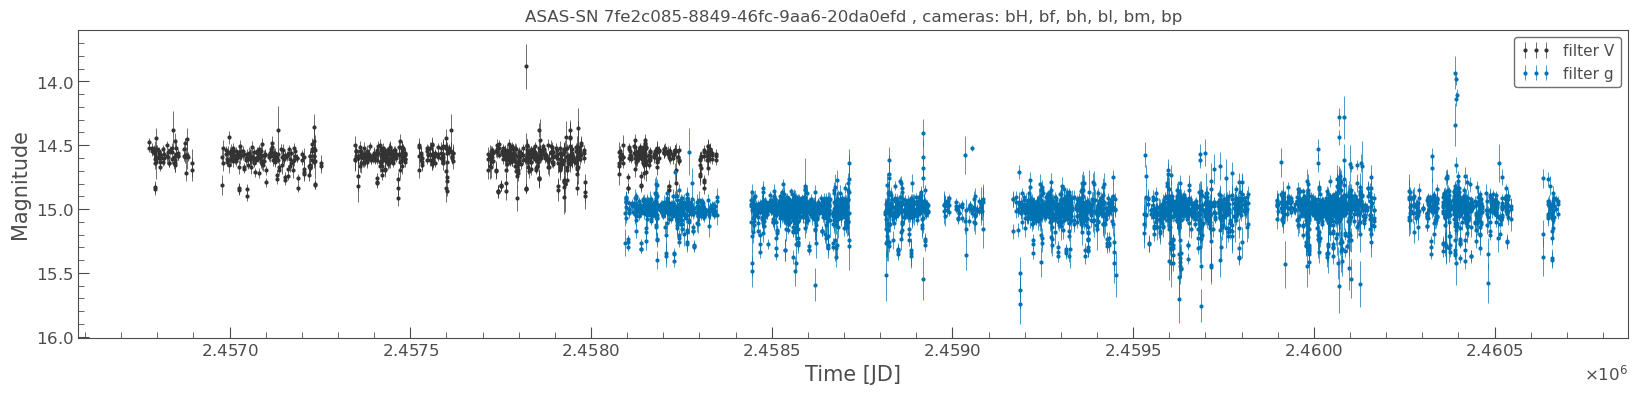

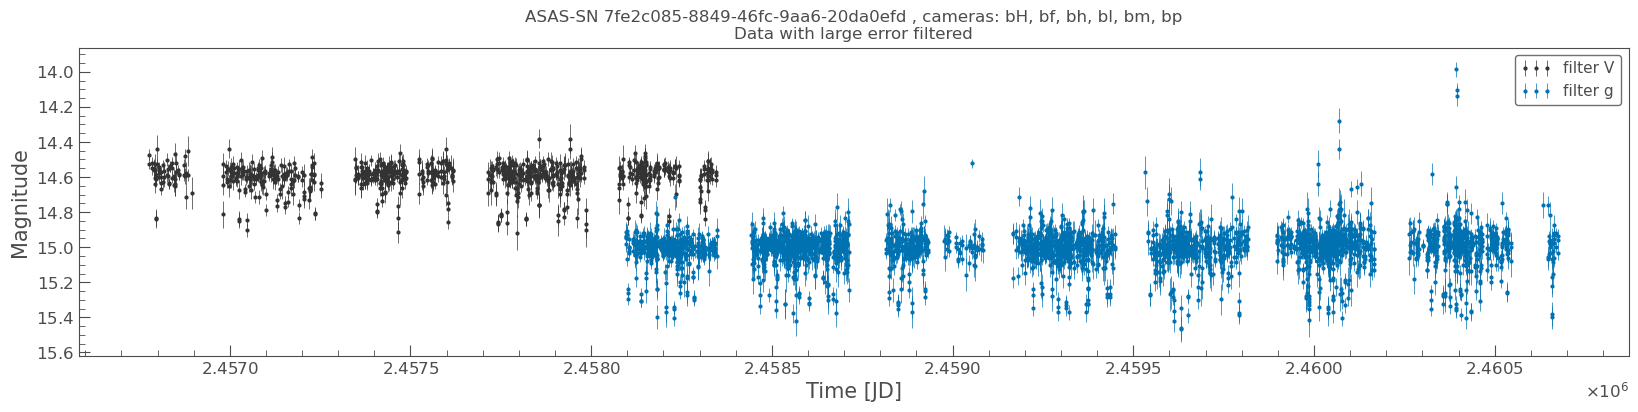

In [176]:
import lightkurve_ext_readers as lker
# reload(lker)
reload(tplt)

# https://asas-sn.osu.edu/sky-patrol/coordinate/7fe2c085-8849-46fc-9aa6-20da0efd20e4
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic61768908_asas_sn_light_curve_7fe2c085-8849-46fc-9aa6-20da0efd20e4.csv")  
# TODO: has values like >14.654 in mag column
lc = lc.select_flux("mag")
lc = lc.remove_nans()
lc = lc.remove_nans(column="flux_err")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.errorbar_partition_by(lc, partition_by_column="filter", ax=ax);
# ax.set_title(ax.get_title());

lc_asassn = lc  # keep the reference in a meaninfgul name for use in subsequent cells
print("Before filtering:", len(lc_asassn), np.nanmedian(lc_asassn.fwhm))  # some basic stats


lc_asassn_original = lc_asassn
lc_asassn = lc_asassn[lc_asassn.mag_err.value < 0.1]  # remove data points with large errors
ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.errorbar_partition_by(lc_asassn, partition_by_column="filter", ax=ax);
ax.set_title(ax.get_title() + "\nData with large error filtered")

print("After filtering:", len(lc_asassn), np.nanmedian(lc_asassn.fwhm))  # some basic stats

## Combining all data

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


TESS # data points: 1073
ASAS-SN V # data points: 916
ASAS-SN g # data points: 3671


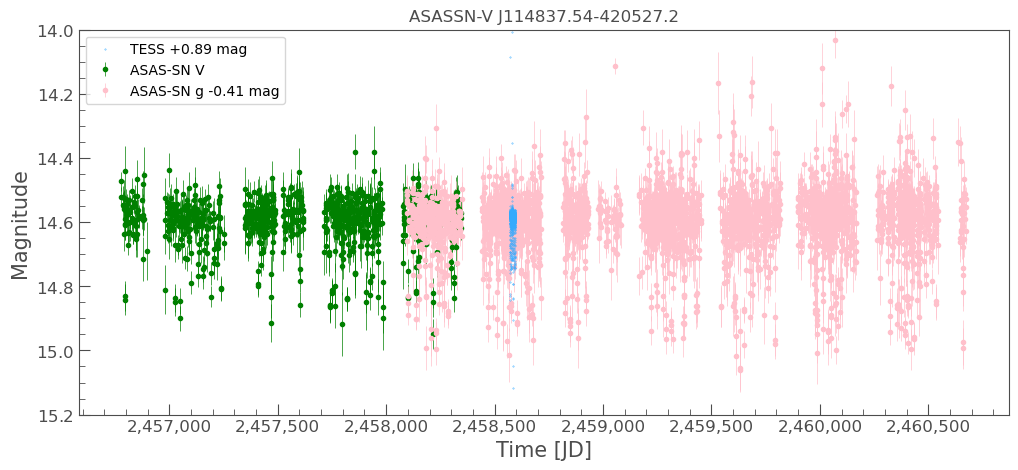

In [177]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True, )
lc_tess = lc_tess.remove_nans()
lc_tess = lc_tess.remove_nans(column="flux_err")

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(
    lc_tess, 
    # base_mag=15.2793,  # target from ExoFOP
    base_mag=lke.combine_magnitudes(15.2793, 13.9838),  # target + contaminant, more accurately reflects the range, it's slighly inaccurate as the target is a variable, but probably sufficient for rough visaul use (exact range will be from ASAS-SN V anyway)
)  
lc_tess = lc_tess.remove_nans()
lc_tess = lc_tess.remove_nans(column="flux_err")
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-SN": lc_asassn,
    }, 
    shift_to="ASAS-SN V" 
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
ax.set_ylim(15.2, 14.0);

## Initial Rough epoch / period / duration

In [178]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_initial = 4.6033 / 2  # 0.5x VSX / ASAS-SN value

epoch_time_hjd_initial = 2457024.802  - period_initial * 0.04  # VSX / ASAS-SN, plus a roughly adjusment after initial inspection
epoch_time_min_ii_hjd_initial = epoch_time_hjd_initial + period_initial / 2
epoch_time_min_ii_hjd_initial = round(epoch_time_min_ii_hjd_initial, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr_min_i_initial = 6.2
duration_hr_min_ii_initial = 6.2


## Crowding-correcting ASAS-SN

#### Determine contaminant V mag
Use transformd V mag from Gaia DR3 Gmag, with zero point adjustment using combined  Vmag max in ASAS-SN V as the reference.

(170, <Quantity 14.5745 mag>)

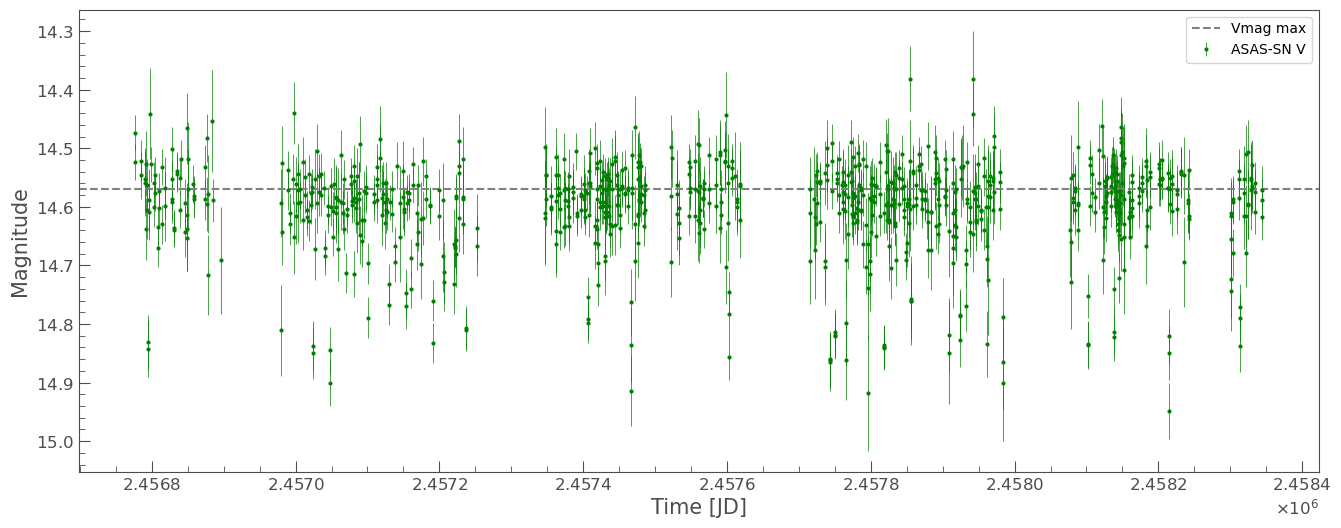

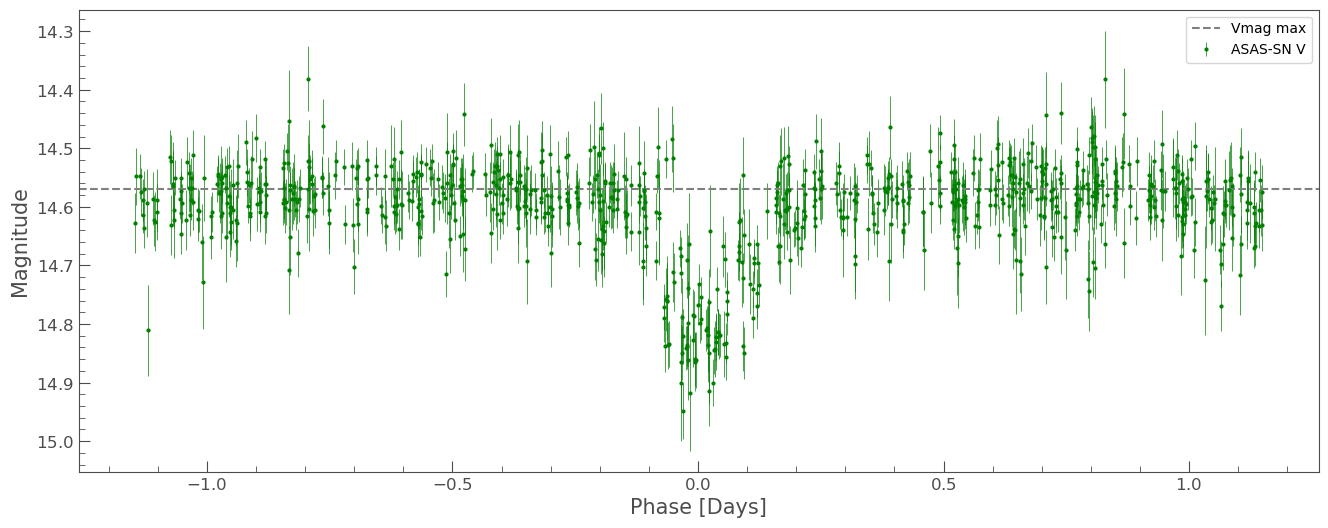

In [196]:
# combined Vmag max:
# - the  existing VSX range of 14.49 - 14.72 V does not fit ASAS-SN V data well here
combined_v_mag_max  = 14.57  # visual inspection based on median around maxima

lc = lc_combined_dict["ASAS-SN V"].copy()
lc.label = "ASAS-SN V"
# lc = lc_combined_dict["TESS"]
ax = tplt.errorbar(lc, c="green", figsize=(16, 6));
ylim = (None, None)
# ylim = (14.9, 14.35)
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

# a rough phase plot
lc_f = lc.fold(period=period_initial, epoch_time=epoch_time_hjd_initial)
ax = tplt.errorbar(lc_f, c="green", figsize=(16, 6));
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

hw = 0.1

# get the median around maxima
lc_trunc = lk.LightCurveCollection([
    lc_f.truncate(-period_initial / 4 - hw, -period_initial / 4 + hw),
    lc_f.truncate(period_initial / 4 - hw, period_initial / 4 + hw),
]).stitch(corrector_func=lambda lc: lc)

len(lc_trunc), np.nanmedian(lc_trunc.flux)

In [197]:
target_gmag_max = 15.56  # from visual inspection Gaia DR3 photometry
target_g_vmag_max = lke.gaia_dr3_mag_to_vmag(target_gmag_max, 0.654)  
print("target V max from Gaia G:", target_g_vmag_max)

contaminant_g_vmag = lke.gaia_dr3_mag_to_vmag(14.651, 1.317)  # from Gaia DR3 Gmag and B-R 
print("contaminant V from Gaia G:", contaminant_g_vmag)  

combined_g_vmag_max= lke.combine_magnitudes(target_g_vmag_max, contaminant_g_vmag)
print("Combined V max from Gaia G:", combined_g_vmag_max)

zero_point_offset = combined_v_mag_max - combined_g_vmag_max
print("Zero point offset:", zero_point_offset)

contaminant_vmag = contaminant_g_vmag + zero_point_offset
contaminant_vmag = round(contaminant_vmag, 2)
print("Contaminant Vmag, zero point adjusted, rounded:", contaminant_vmag)

target V max from Gaia G: 15.66595371307536
contaminant V from Gaia G: 15.00066731649462
Combined V max from Gaia G: 14.530556412748513
Zero point offset: 0.03944358725148689
Contaminant Vmag, zero point adjusted, rounded: 15.04


Target Max in Gaia DR3 G band

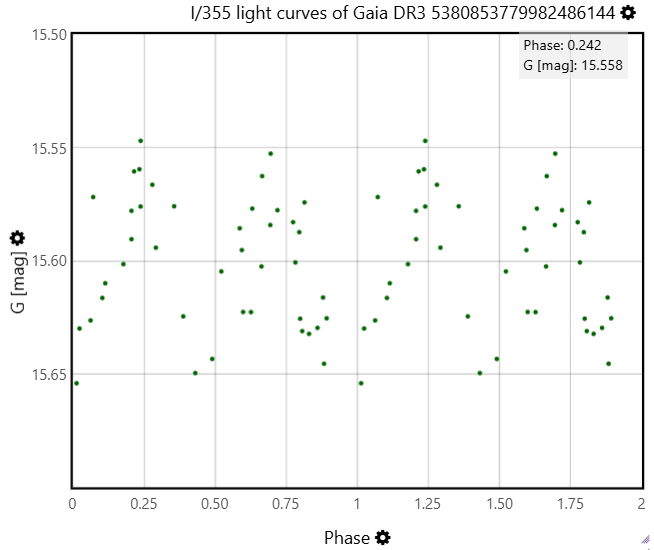

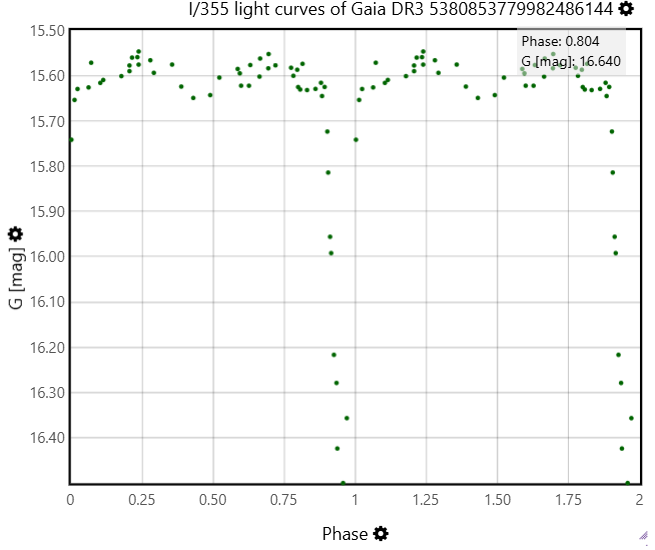


#### Beblend ASAS-SN data and TESS data

In [199]:

lc_asassn_v_c = lke.deblend_mag(lc_combined_dict["ASAS-SN V"], contaminant_vmag)
# Note: for ASAS-SN g, we deblend the ASAS-SN g **zero-shfited to V**, 
lc_asassn_g_c = lke.deblend_mag(lc_combined_dict["ASAS-SN g"], contaminant_vmag) 

lc_tess_c = lke.deblend_mag(lc_tess[lc_tess.flux.value < 13.9838], 13.9838)  # faint outliers in TESS data would cause deblend fail (error in log), remove thouse outliers
lc_combined_dict_c = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess_c, 
     "ASAS-SN V": lc_asassn_v_c,
     "ASAS-SN g": lc_asassn_g_c,
    }, 
    shift_to="ASAS-SN V"  
)



C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1297: RuntimeWarning: invalid value encountered in log10
  target_mag = contaminant_mag - 2.5 * np.log10(10 ** ((contaminant_mag - blended_mag) * 0.4) - 1)


#### plot combined results with initial period / epoch (with crowding correction)

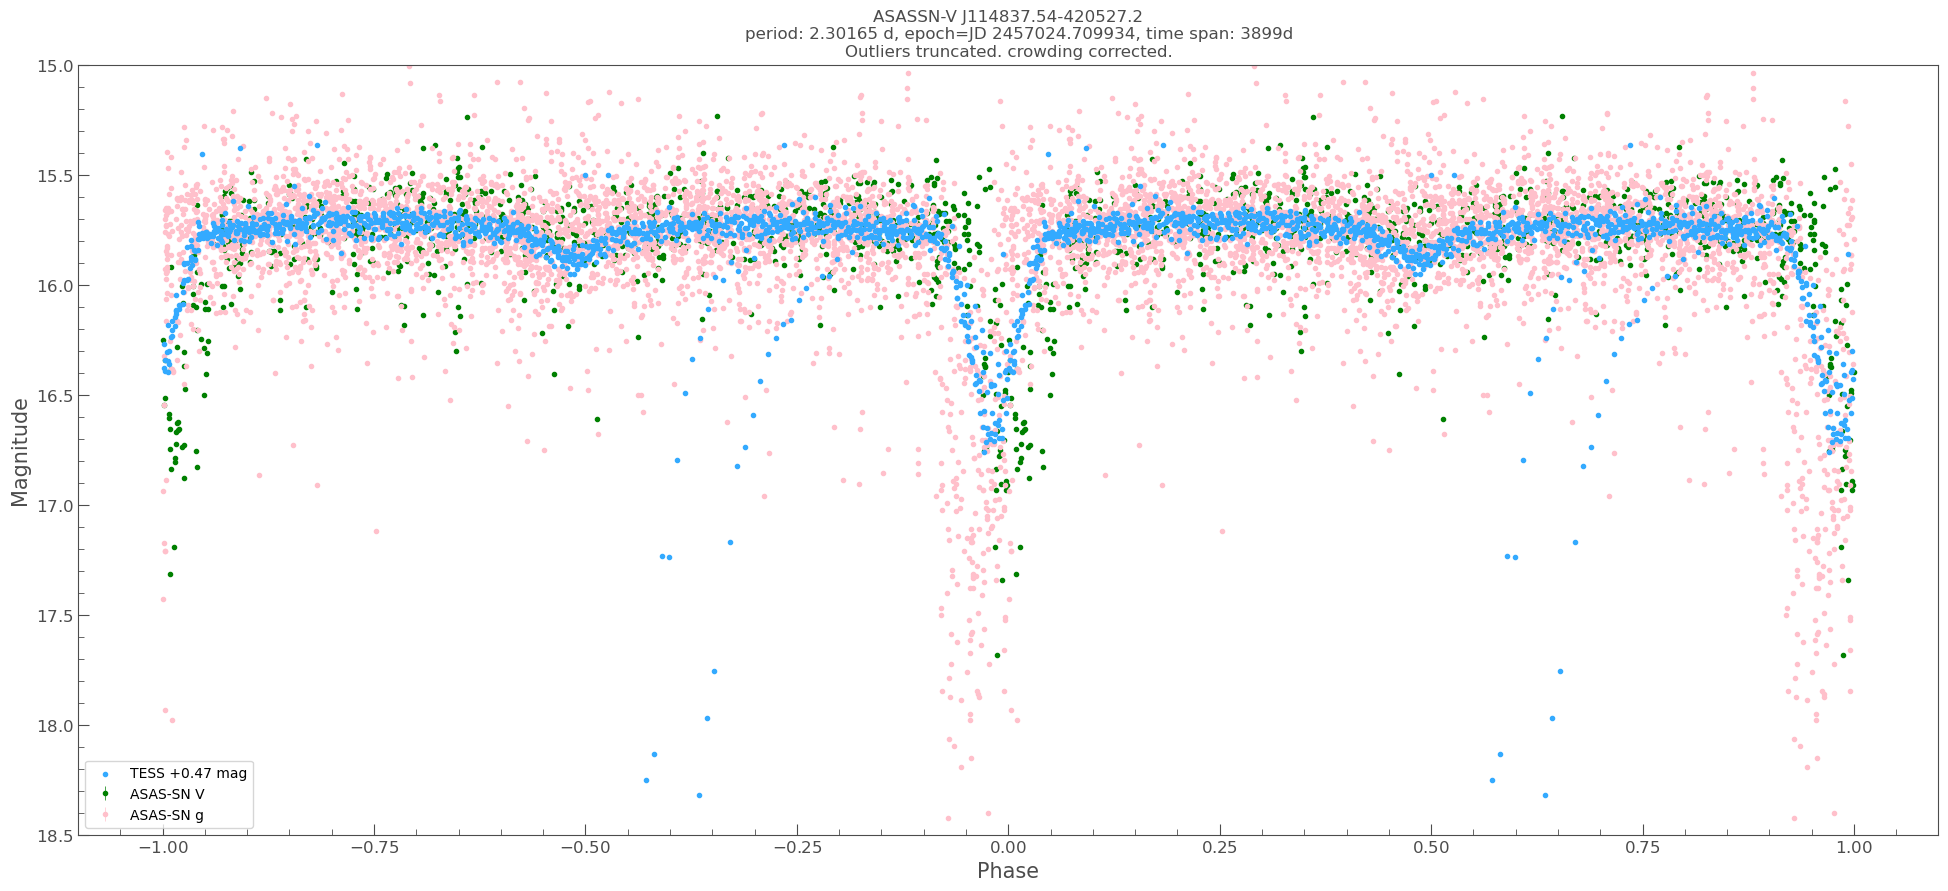

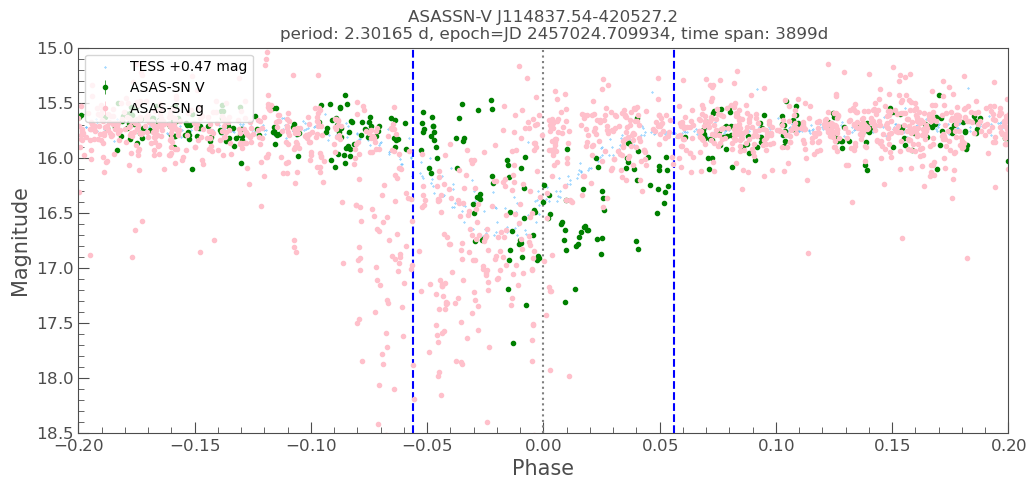

In [210]:
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
plot_options[0][1]["s"] = 9  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[1][1]["markersize"] = 9  # make markers for Hp larger

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd_initial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (18.5, 15.0)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd_initial, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_ylim(*ylim);
ax.set_xlim(-0.2, 0.2);  # to see primary in details

# Copy the deblending result to VSX deblend spreadsheet to ensure the implementaion is correct
# lc_combined_dict["ASAS-SN V"].remove_nans().to_pandas().to_clipboard()
# lc_asassn_v_c.to_pandas()["flux"].to_clipboard()


## Refine epoch / period / duration

In [206]:
lke.to_normalized_flux_from_mag

0.25833333333333336

In [247]:
lcc = []
# here we use the *combined flux*  (rather than deblneded one)
# because the deblend procedure loses error (the error will still be useful in MCMC)
for key, lc in lc_combined_dict.items():
    if key == "TESS":
        # the amplitude of TESS is noticably smaller than others, 
        # skip them to make the period fits (in MCMC) easier
        continue
    lc = lc.copy()
    lc["band"] = key
    lc = lke.to_normalized_flux_from_mag(lc)
    lc = lc["time", "flux", "flux_err"]   # avoid incompatibility in other unused columns in stitch() below
    lcc.append(lc)
lcc = lk.LightCurveCollection(lcc)
lc = lcc.stitch();

# axs = tplt.plot_skip_data_gap(lc);

# remove obvious outliers
# lc = lc.truncate(0.5, 1.2, column="flux").remove_nans();


### First refinment: BLS on combined data

In [233]:
lc["quality"] = 0
lc["cadenceno"] = np.arange(0, len(lc))
lc.interact_bls();

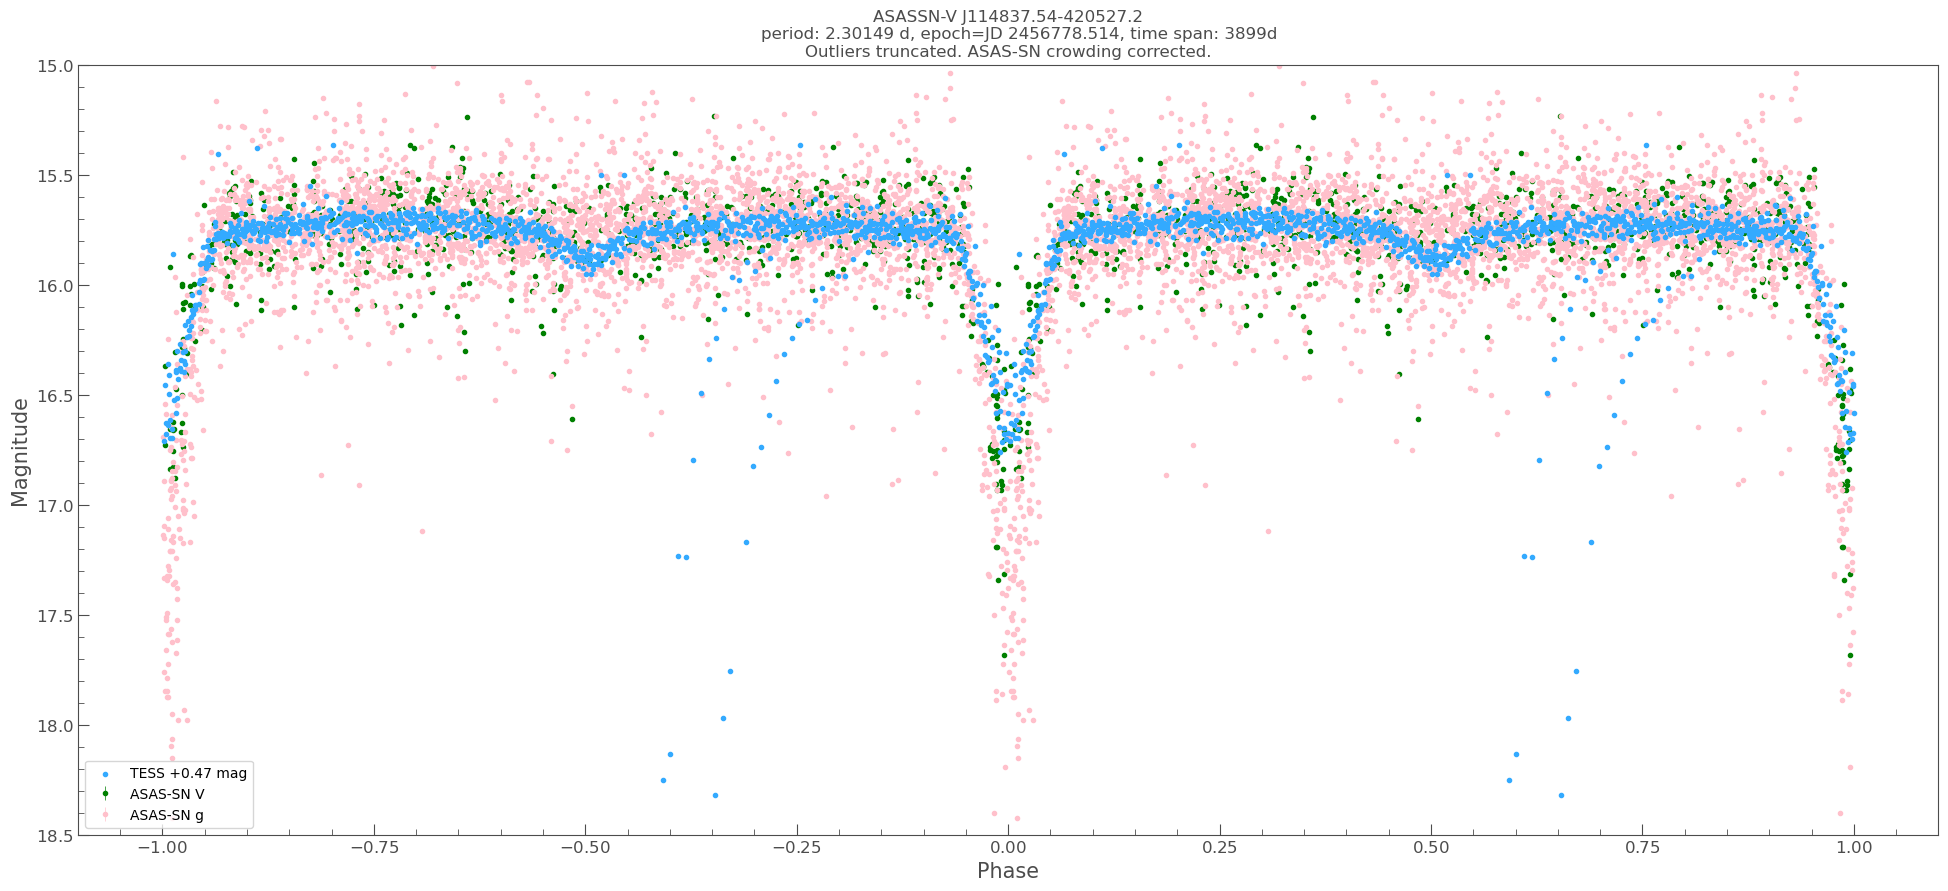

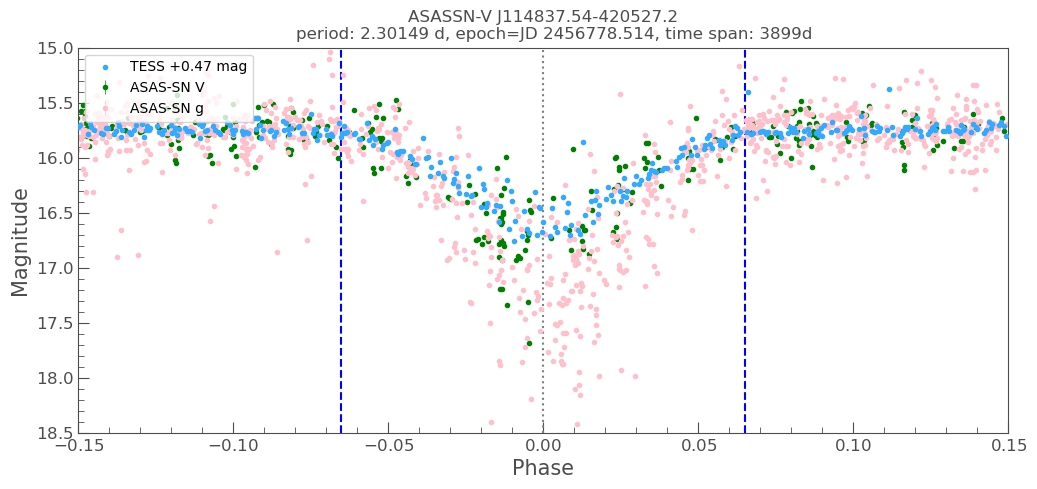

In [234]:
# from lc.interact_bls(), duration: 0.3 d, BLS resolution: 6600
# Period: 2.3014921 days, T0: 2456778.5138
period_trial = 2.30149 # from BLS reuslt 
epoch_time_hjd_trial = 2456778.514  # from BLS reuslt
duration_hr_min_i_trial = 7.2  # from BLS's 7.2 (24 * 0.3)


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
# ylim = (None, None)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    plot_options=plot_options,
    duration_hr=duration_hr_min_i_trial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.15, 0.15);  # to see primary in details

### 2nd refinement: use MCMC to model primary eclipses

len(lc_f_min_i): 404


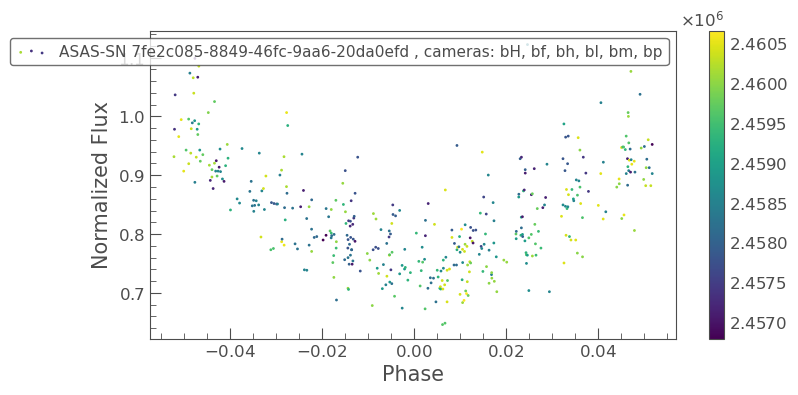

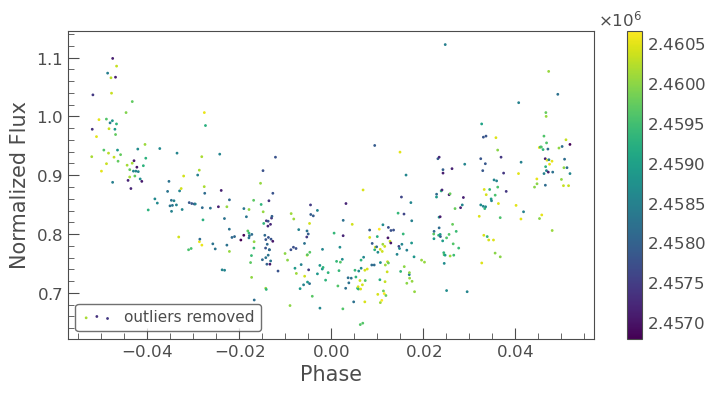

In [248]:
# Prepare the clipped LC for MCMC
lc_f_min_i = lc.fold(epoch_time=epoch_time_hjd_trial, period=period_trial, normalize_phase=True)
lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_trial / 24 * 0.40) / period_trial, (0 + duration_hr_min_i_trial /24 * 0.40) / period_trial)
ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value);


lc_f_min_i = lc.remove_outliers(sigma_lower=6, sigma_upper=5).fold(epoch_time=epoch_time_hjd_trial, period=period_trial, normalize_phase=True)
lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_trial / 24 * 0.40) / period_trial, (0 + duration_hr_min_i_trial /24 * 0.40) / period_trial)
ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value, label="outliers removed");

print("len(lc_f_min_i):", len(lc_f_min_i))


In [249]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = lc_f_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.28, 0, 0.034, 0.9]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)
# etv_functions.plot_initial_guess(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

100%|██████████████████████████████████████████████████████████| 5000/5000 [01:11<00:00, 69.75it/s]


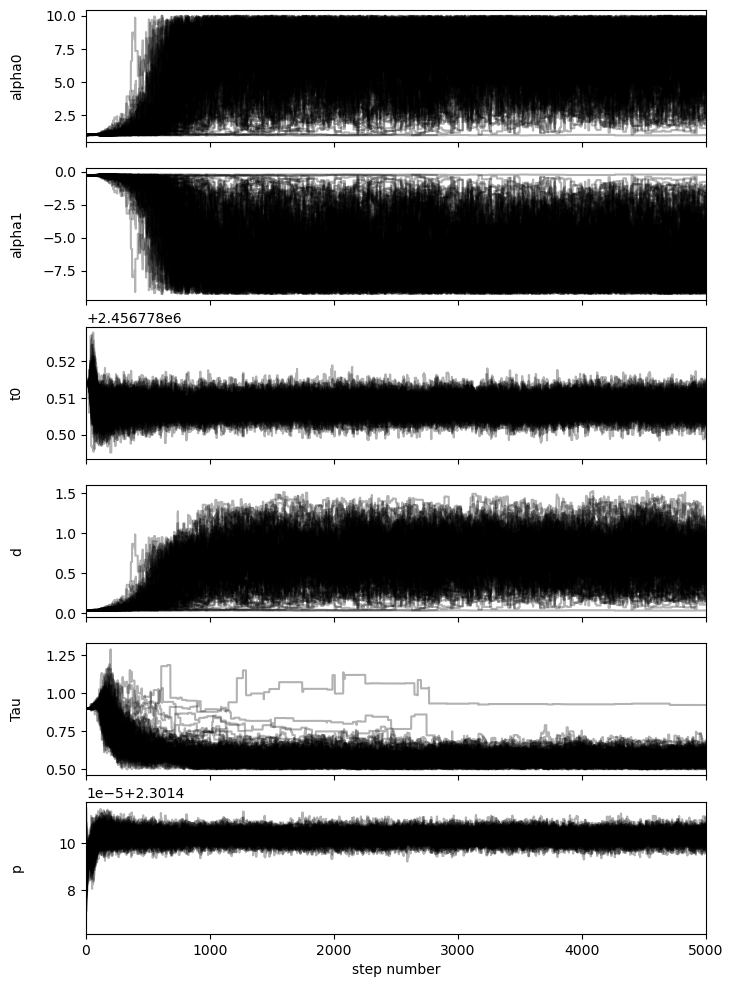

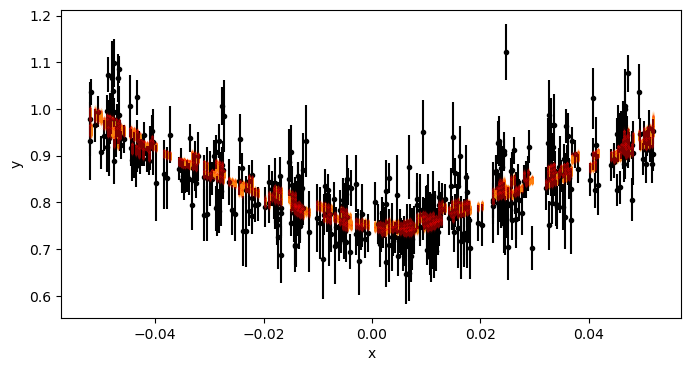

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 7.143518086381655, -6.4044731586425865, 2456778.5079101324, 0.6650526975978901, 0.5718431278981244, 2.3015028208420967
std_p: 2.3320477368591017e-06


In [251]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.28, epoch_time_hjd_trial,  0.034, 0.9, period_trial],
    nruns=5000, discard=4000,
    # nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_p:", fit_params_p_stats["std_p"])


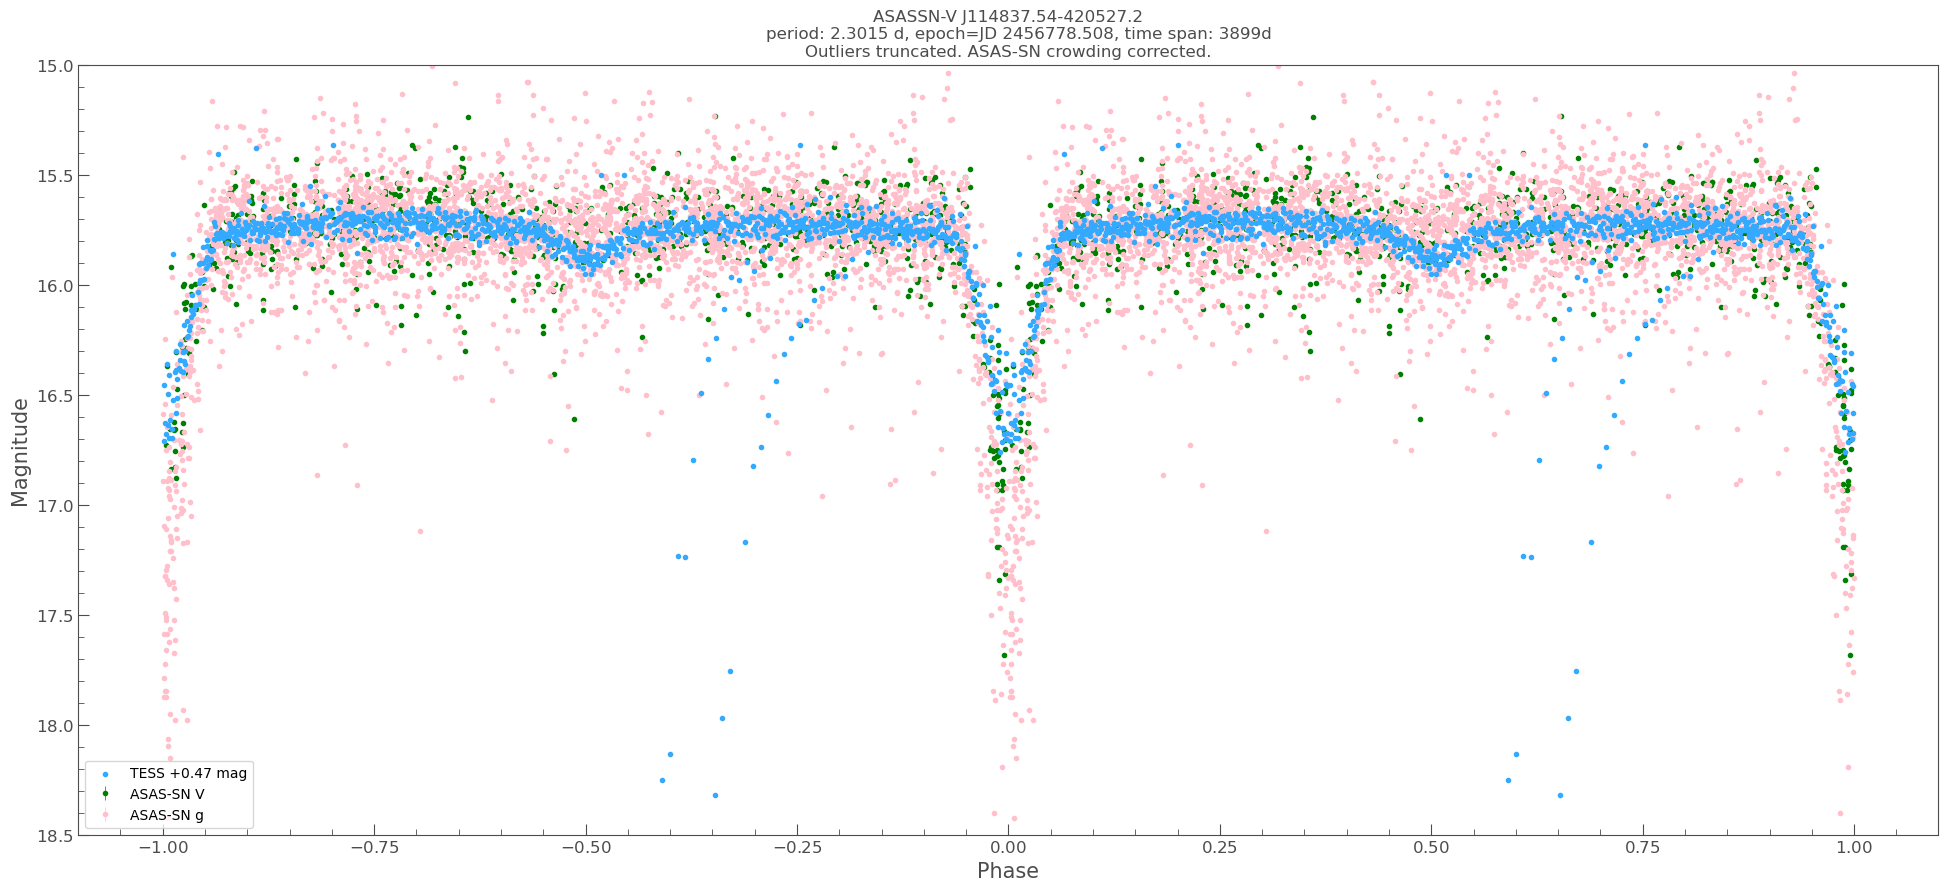

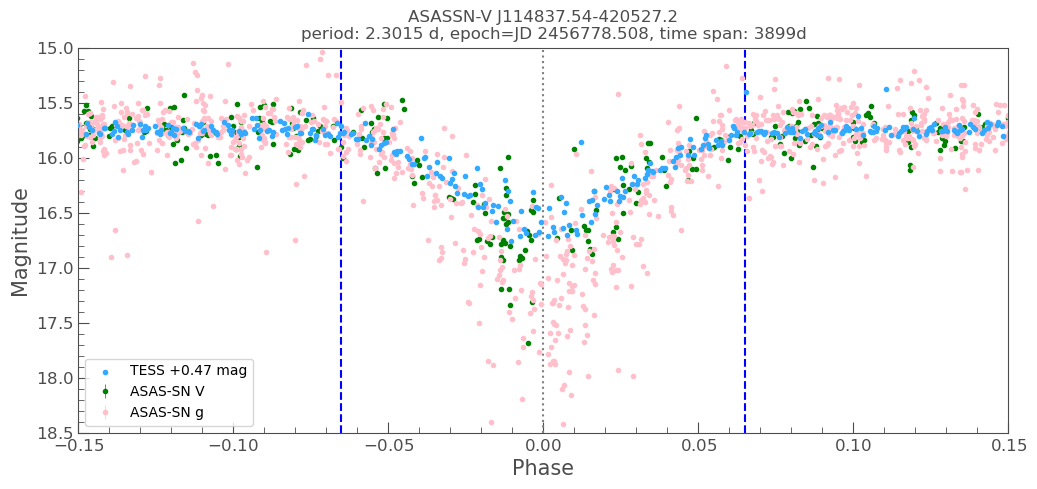

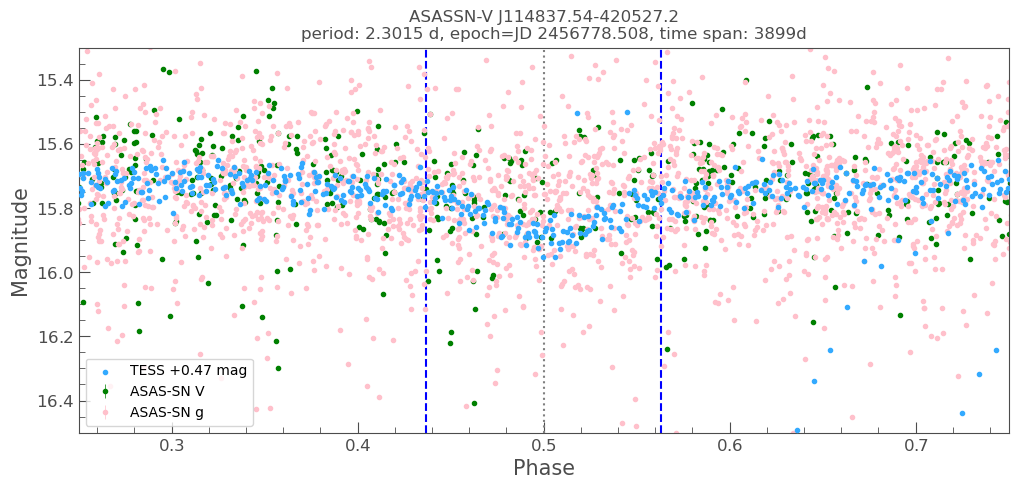

In [259]:
# reload(lkem)

# MCMC
# mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 7.143518086381655, -6.4044731586425865, 2456778.5079101324, 0.6650526975978901, 0.5718431278981244, 2.3015028208420967
# std_p: 2.3320477368591017e-06


period_trial2 = 2.30150   # MCMC 
epoch_time_hjd_trial2 = 2456778.508 # MCMC 
duration_hr_min_i_trial2 = 7.2 # manual fit
# duration_hr_min_ii_trial2 = 7


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
# ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# zoom plot
# - make TESS more visible: moved to the front, and larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["zorder"] = 3
plot_options_zoom[0][1]["s"] = 9
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial2,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.15, 0.15);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_trial2,  # for plotting only
    duration_midpoint_phase=0.5,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(16.5, 15.3);
ax.legend(loc="lower left");
ax.axvline(0.5, c="gray", linestyle="dotted");
ax.set_xlim(0.25, 0.75);  # to see secondary in details

In [ ]:
# TODO: trying out SO's contaminat Vmag of 12.16, to see the difference. Final decision is pending.

# # reload(lke)
# lc_asassn_v_c = lke.deblend_mag(lc_combined_dict["ASAS-SN V"].remove_nans(), 12.16)  # contaminant_vmag
# # Note: for ASAS-SN g, we deblend the ASAS-SN g **zero-shfited to V**, 
# lc_asassn_g_c = lke.deblend_mag(lc_combined_dict["ASAS-SN g"], 12.16) 

# lc_combined_dict_c = lkem.combine_multi_bands_and_shift(
#     {"TESS": lc_tess, 
#      "ASAS-SN V": lc_asassn_v_c,
#      "ASAS-SN g": lc_asassn_g_c,
#     }, 
#     shift_to="ASAS-SN V"  
# )


# # MCMC
# # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9976548294985115, -0.3776706901718959, 2457424.3450087635, 0.028354040645499064, 0.8520014331800578, 1.6430376979922796
# # std_p: 2.7162954619850995e-07

# period_trial2 = 1.643038  # MCMC 
# epoch_time_hjd_trial2 = 2457424.345 # MCMC 
# # duration_hr_min_i_trial2 = 4  # manual fit
# duration_hr_min_i_trial2 = 4.65  # SO feedback 
# duration_hr_min_ii_trial2 = duration_hr_min_i_trial2

# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     lc_combined_dict_c,
#     period=period_trial2,
#     epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
#     figsize=(24, 10),
#     target_name=primary_name,
#     plot_options=plot_options,
# );
# ylim = (13.7, 12.4)
# ax.set_ylim(*ylim);
# ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# # zoom plot
# plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
# plot_options_zoom[0][1]["zorder"] = 4
# plot_options_zoom[0][1]["s"] = 2

# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     lc_combined_dict_c,
#     period=period_trial2,
#     epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_name=primary_name,
#     duration_hr=duration_hr_min_i_trial2,  # for plotting only
#     figsize=(12, 5),
#     plot_options=plot_options_zoom,
#     mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
# );
# ax.set_ylim(*ylim);
# ax.legend(loc="upper left");
# ax.axvline(0, c="gray", linestyle="dotted");
# ax.set_xlim(-0.1, 0.1);  # to see primary in details


# # zoom plot - Min II
# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     lc_combined_dict_c,
#     period=period_trial2,
#     epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_name=primary_name,
#     duration_hr=duration_hr_min_ii_trial2,  # for plotting only
#     duration_midpoint_phase=0.5,
#     figsize=(12, 5),
#     plot_options=plot_options_zoom,
#     mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
# );
# ax.set_ylim(*ylim);
# ax.legend(loc="upper left");
# ax.axvline(0.5, c="gray", linestyle="dotted");
# ax.set_xlim(0.4, 0.6);  # to see primary in details


# # ---

# # %matplotlib widget
# %matplotlib inline

# # From TESS data (shifted back to TESS mag)

# lc = lc_combined_dict_c["ASAS-SN V"]
# # lc = lc_combined_dict_c["TESS"]
# # max_flux_mag = lc.flux.min().value  #
# # min_flux_mag = lc.flux.max().value
# median_flux_mag = np.nanmedian(lc.flux.value)

# lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
# print("Min mag # num data points:", len(lc_zoom_min))
# min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# # fold around Min II, find the min flux
# lc_zoom_max_p1 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.25, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
# lc_zoom_max_p2 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.75, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
# lc_zoom_max = lk.LightCurveCollection([lc_zoom_max_p1, lc_zoom_max_p2]).stitch(corrector_func=lambda lc: lc)
# print("Max mag # num data points:", len(lc_zoom_max))
# max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)

# lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 1)  # 2x period plot
# ax = tplt.lk_ax(figsize=(12, 8))
# ax = tplt.scatter(lc_f, s=0.5, ax=ax);
# ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
# ax.axhline(max_flux_mag, c="red", linestyle="dashed", label="Max")
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min")
# ax.legend(loc="lower right");
# # ax.set_xlim(-0.15, 0.15); ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

# ax = tplt.scatter(lc_zoom_min, marker="o");
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# # lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# # ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# # ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# # ax.legend(loc="lower right");

# # Sebatsian suggestion: 9.46 - 9.76, based on corrected Hipparcos, INTEGRAL-OMC
# print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag]])


### Final epoch / period / duration

In [ ]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_trial2
epoch_time_hjd_final = epoch_time_hjd_trial2
duration_hr_min_i_final = duration_hr_min_i_trial2 
duration_hr_min_ii_final = duration_hr_min_ii_trial2 

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final)

# Min II : at phase 0.5


## Determine Magnitude Range (crowding corrected ASAS-SN V)


In [ ]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict_c["ASAS-SN V"]
# lc = lc_combined_dict_c["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
print("Min mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# fold around Min II, find the min flux
lc_zoom_max_p1 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.25, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max_p2 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.75, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max = lk.LightCurveCollection([lc_zoom_max_p1, lc_zoom_max_p2]).stitch(corrector_func=lambda lc: lc)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 1)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, s=0.5, ax=ax);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(max_flux_mag, c="red", linestyle="dashed", label="Max")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min")
ax.legend(loc="lower right");
# ax.set_xlim(-0.15, 0.15); ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

ax = tplt.scatter(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag]])


## Determine Amplitude (TESS) - SKIPPED

In [ ]:
# # From TESS data (shifted back to TESS mag)

# lc = lc_combined_dict["TESS"]
# lc = lc - lc.flux_shift
# # max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
# median_flux_mag = np.nanmedian(lc.flux.value)

# lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
# min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
# min_amp_mag = abs(min_flux_mag - median_flux_mag) 

# # fold around Min II, find the min flux
# lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
# min_ii_amp_mag = abs(min_ii_flux_mag - median_flux_mag) 

# lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
# ax = tplt.scatter(lc_f, s=0.5);
# ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
# ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend();

# print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])
# print([f"{v:.2f}" for v in [median_flux_mag, min_amp_mag, min_ii_amp_mag]])

## Plots for VSX

In [ ]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict_c, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "\nASAS-SN crowding corrected.");

#### Phase Plot, with crowding correction 



In [ ]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


## VSX Report Table

In [ ]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [ ]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  
other_names += ",Gaia DR3 6093967575460032896"  # it was the primary_name but per SO, keep the existing primary_name 
other_names += ",UCAC4 205-078706"  # UCAC4 resolves the 2 stars -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ675e2d18351e6c&-out.add=.&-source=I/322A/out&UCAC4===205-078706

# SO feedback: separation is 3.0" instead of 2.9"
# contaminant_vmag. leave it as-is (no resolution)
# - I got:   12.13, after calibrating from 12.16 (V from Gaia DR3 g), range is 12.69 - 13.24
# - SO uses: 12.16 (V from Gaia DR3 g), range should then be: 12.64 - 13.16 (the contaminant is fainter, so the target should be brighter)
remarks = f"""ASAS-SN data contaminated by Gaia DR3 6093967571164369920 (V={contaminant_vmag}; 3.0" to the W). Range has been corrected."""  

revision_comment = "Identification from 2022yCat.1358....0G. Period, epoch and eclipse duration from ASAS-SN and TESS data. Range from ASAS-SN V data. Position and spectral type from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    # SO feedback: don't change the primary name when the 2 stars are so close (3") and the existing primary_name is from a variable star catalog (the name served as a suggestion of the discoverer
    Primary_Name="ASASSN-V J140052.13-490014.8",  
    Other_Names=other_names,
    # Variable_Type="EA",  # no change
    Spectral_Type="F",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_mag:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_flux_mag:.2f}", 
    Minimum_Magnitude_band="V",  
    Minimum_Is_Amplitude=False,
    Period=period_final,
    Epoch=epoch_time_hjd_final,
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.0f}",
    # Discoverer="Gaia collaboration",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.GAIA_DR3_VAR_N,
    Reference0_Bib=BIBS.GAIA_DR3_VAR_B,
    Reference1_Name=BIBS.QLP_N,
    Reference1_Bib=BIBS.QLP_B,
    Reference2_Name=BIBS.ASAS_SN_N,
    Reference2_Bib=BIBS.ASAS_SN_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic1050594841_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic1050594841_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
""")


# Scratch